<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Deep-Learning/Datasets/cifar10_dataset_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 dataset

Train neural network to classify images in CIFAR-10 dataset. 

The dataset consists: 
+ 60,000 32x32 colour images in 10 classes, with 6000 images per class. 
  + 50,000 training images, and 
  + 10,000 test images.

## Import libraries

In [0]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [0]:
import mlflow
import mlflow.pytorch

In [0]:
class Params(object):
  def __init__(self, batch_size, epochs, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.log_interval = log_interval

args = Params(batch_size=512, epochs=10, log_interval=20)

## Load dataset

In [4]:
trainset = datasets.CIFAR10(root='./Data', train=True, transform = transforms.ToTensor(), download=True)
testset = datasets.CIFAR10(root='./Data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)

In [7]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualize sample images

In [0]:
def imshow(images, labels):
  plt.imshow(images.numpy().transpose((1, 2, 0)))
  plt.title([trainset.classes[label.item()] for label in labels])
  plt.axis('off')
  plt.show()

torch.Size([4, 3, 32, 32])


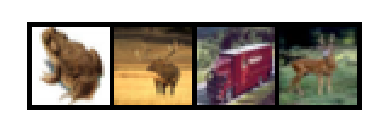

In [9]:
images, labels = next(iter(trainloader))

print(images.shape)
images = torchvision.utils.make_grid(images)

imshow(images, labels)

## Build Neural network to classify images  

### Prepare methods to train and evaluate different models

In [0]:
def train(model, criterion, optimizer, trainloader, device, epoch):
  model.train()
  running_loss = 0
  for batch_id, data in enumerate(trainloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()                 # Reset parameters

    outputs = model(images)               # Forward pass
    loss = criterion(outputs, labels)     # Compute loss
    loss.backward()                       # Backpropogation
    optimizer.step()                      # Update parameters

    running_loss += loss.item()

    if batch_id % args.log_interval == 0:
      mlflow.log_metric('train_loss', loss.data.item()/len(images)*1000)

In [0]:
def eval_(model, criterion, testloader, device, epoch):
  model.eval()
  total = 0
  correct = 0
  confusion_matrix = np.zeros([10, 10])
  test_loss = 0

  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      test_loss += criterion(outputs, labels).data.item()

      total += len(images)
      correct += (predicted == labels).sum().data.item()

      for x, y in zip(predicted.numpy(), labels.numpy()):
        confusion_matrix[x][y] += 1

    test_loss /= len(testloader)
    accuracy = 100.0*correct/total

    mlflow.log_metric('test_loss', test_loss)
    mlflow.log_metric('accuracy', accuracy)
    print(f'Accuracy:{accuracy}')

    if epoch == args.epochs:
      classes = np.arange(10)
      fig, ax = plt.subplots()
      im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)
      ax.set(xticks=np.arange(confusion_matrix.shape[1]),
              yticks=np.arange(confusion_matrix.shape[0]),
              xticklabels=classes, yticklabels=classes,
              ylabel='True label',
              xlabel='Predicted label',
              title='Epoch %d' % epoch)
      thresh = confusion_matrix.max() / 2.
      for i in range(confusion_matrix.shape[0]):
          for j in range(confusion_matrix.shape[1]):
              ax.text(j, i, int(confusion_matrix[i, j]),
                      ha="center", va="center",
                      color="white" if confusion_matrix[i, j] > thresh else "black")
        
      fig.tight_layout()
        
      image_path = 'images/%s.png' % (expt_id)
      plt.savefig(image_path)
      mlflow.log_artifact(image_path)

### Fetch computing device

In [0]:
device = torch.device('cpu') #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
print(device)

cpu


### Load dataset again to have larger batch_size

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, args.batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, args.batch_size, shuffle=False, num_workers=2)

### Neural networks

#### Basic neural network

In [0]:
class NN_Basic(nn.Module):
  def __init__(self, n_hidden_nodes):
    super(NN_Basic, self).__init__()

    self.classifier = nn.Sequential(
        nn.Linear(3*32*32, n_hidden_nodes),
        nn.ReLU(),
        nn.Linear(n_hidden_nodes, 10)
    )
  
  def forward(self, x):
    x = x.view(x.size()[0], -1)
    out = self.classifier(x)
    return out

#### Hyperparameter tuning loop

In [0]:
mlflow.set_experiment('Hidden_Layer=1')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [16, 32, 48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = NN_Basic(hidden_nodes).to(device)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(model, loss_fn, opt, trainloader, device, epoch)
                    eval_(model, loss_fn, testloader, device, epoch)

                mlflow.pytorch.log_model(model, "models")

Above loop gave best accuracy(=46.21) for following params:
+ Batch size: 512
+ Hidden nodes: 48
+ Lr: 0.02
+ Momentum: 0.9

Now, I'll try to run the above configuration for more epochs to see maximum accuracy our simple model can reach

In [0]:
mlflow.set_experiment('Hidden_Layer=1,FixedHidden_LR_Momentum')

for lr in [0.02]:
    for momentum in [0.9]:
        for hidden_nodes in [48]:
            for n_epochs in [10, 20, 40, 50]:
              expt_id = '%d_%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes, n_epochs)

              print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d, Epochs = %d\n' % (lr, momentum, hidden_nodes, n_epochs))

              model = NN_Basic(hidden_nodes).to(device)

              loss_fn = nn.CrossEntropyLoss()
              opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

              args.epochs = n_epochs
              with mlflow.start_run() as run:  
                  for key, value in vars(args).items():
                      mlflow.log_param(key, value)
                  mlflow.log_param('lr', lr)
                  mlflow.log_param('momentum', momentum)
                  mlflow.log_param('hidden_nodes', hidden_nodes)

                  for epoch in range(1, args.epochs + 1):
                      train(model, loss_fn, opt, trainloader, device, epoch)
                      eval_(model, loss_fn, testloader, device, epoch)

                  mlflow.pytorch.log_model(model, "models")

Above loop gave best accuracy(=49.14) for following params:
+ Batch size: 512
+ Hidden nodes: 48
+ Lr: 0.02
+ Momentum: 0.9
+ Epochs: 40

Now, I'll try to add Batch Normalization layer in Basic model to see if it helps in getting higher accuracy

#### Basic Neural network with batch normalization

In [0]:
class NN_Basic_BatchNorm(nn.Module):
  def __init__(self, n_hidden_neurons):
    super(NN_Basic_BatchNorm, self).__init__()

    self.classifier = nn.Sequential(
        nn.Linear(3*32*32, n_hidden_neurons),
        nn.BatchNorm1d(n_hidden_neurons),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons, 10)
    )

  def forward(self, x):
    x = x.view(x.size()[0], -1)
    out = self.classifier(x)

    return out

##### Hyperparameter tuning

In [0]:
mlflow.set_experiment('Hidden_Layer=1,BatchNorm_Dropout')

for lr in [0.01, 0.02]:
  for momentum in [0.9]:
    for hidden_nodes in [48, 96]:
      previous_epochs = 0
      for n_epochs in [10, 20, 50]:

        exp_id = f'{int(lr*100)}_{int(momentum*100)}_{hidden_nodes}_{n_epochs}'

        print(f'Lr={lr}, Momentum={momentum}, Hidden_Neurons={hidden_nodes}, Epochs={n_epochs}')

        model = NN_Basic_BatchNorm(hidden_nodes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        
        args.epochs = n_epochs
        with mlflow.start_run() as run:
          for key, value in vars(args).items():
            mlflow.log_param(key, value)
          mlflow.log_param('lr', lr)
          mlflow.log_param('momentum', momentum)
          mlflow.log_param('hidden_nodes', hidden_nodes)

          for epoch in range(n_epochs - previous_epochs):
            train(model, criterion, optimizer, trainloader, device, epoch)
            eval_(model, criterion, testloader, device, epoch)
          
          mlflow.pytorch.log_model(model, 'models')
        
        previous_epochs = n_epochs
        

Above loop gave best accuracy(=47.23) for following params:
+ Batch size: 512
+ Hidden nodes: 96
+ Lr: 0.02
+ Momentum: 0.9
+ Epochs: 10

Now, I'll try to add another hidden layer in Basic model and check the accuracy